# Gulf of Maine Bottom Temperature Timeseries

Take the Gulf of Maine Shapefile used for the sst reports. Process Daily SST/BT & SSS/SBS and then process the climatology and the anomalies for each. Use area-weighting of cells to be rigorous and then save this for use in the warming report.

In [1]:
####  Libraries  ####
import xarray as xr
import dask
import os
import numpy as np
import geopandas as gpd
import regionmask
import re

# Paths to resources
box_path = "/Users/adamkemberling/Library/CloudStorage/Box-Box/"
lobecol_path = f"{box_path}Mills Lab/Projects/Lobster ECOL/Spatial_Defs/"
glorys_path = f"{box_path}RES_Data/GLORYs/"
sst_regions = f"{box_path}RES_Data/Shapefiles/gmri_sst_focal_areas/"

# daily data, surface-bottom
surfbot_box_path = f"{glorys_path}NE_Shelf_Surfbot_Daily/"

# File paths, no ds_store
# Pattern matching for .nc only
pattern = r".*\.nc$"  # Match all files ending with ".nc"

# list the .nc files
fpaths_glorys = []
for filename in os.listdir(surfbot_box_path):
    if re.search(pattern, filename):
        fpaths_glorys.append(f"{surfbot_box_path}{filename}")

# Check files are there
#fpaths_glorys[0:6]
surfbot_ds = xr.open_mfdataset(fpaths_glorys)
surfbot_ds

<xarray.Dataset> Size: 13GB
Dimensions:       (time: 11762, latitude: 132, longitude: 226)
Coordinates:
  * time          (time) datetime64[ns] 94kB 1993-01-01 ... 2025-03-25
  * longitude     (longitude) float32 904B -75.67 -75.58 -75.5 ... -57.0 -56.92
  * latitude      (latitude) float32 528B 35.25 35.33 35.42 ... 46.0 46.08 46.17
Data variables:
    bottom_temp   (time, latitude, longitude) float64 3GB dask.array<chunksize=(365, 132, 226), meta=np.ndarray>
    surface_temp  (time, latitude, longitude) float64 3GB dask.array<chunksize=(365, 132, 226), meta=np.ndarray>
    surface_sal   (time, latitude, longitude) float64 3GB dask.array<chunksize=(365, 132, 226), meta=np.ndarray>
    bottom_sal    (time, latitude, longitude) float64 3GB dask.array<chunksize=(365, 132, 226), meta=np.ndarray>
    bottom_depth  (time, latitude, longitude) float32 1GB dask.array<chunksize=(365, 132, 226), meta=np.ndarray>

In [2]:
# Load the bounding box used in the other reports
gom_box = gpd.read_file(f"{sst_regions}apershing_gulf_of_maine.geojson")
# gom_box.plot()

## Process Regional Timeseries


In [3]:
# Function to mask
def calc_ts_mask(grid_obj, shp_obj, shp_name):
  """
  Return a timeseries using data that falls within shapefile. 
  
  Standard deviation
  not included so that this function can be used for any period of time.
  
  Args:
    grid_obj       : xr.Dataset of the desired input data to mask
    shp_obj        : shapefile polygon to use as a mask
    shp_name (str) : String to use as name when making mask
  """

  #### 1. Make the mask
  area_mask = regionmask.Regions(
    shp_obj.geometry,
    name = shp_name)

  #### 2. Mask the array with gom_mask to get nan test
  # mask = area_mask.mask(grid_obj, lon_name = "longitude", lat_name = "latitude")
  mask = area_mask.mask(grid_obj["longitude"], grid_obj["latitude"])

  #### 3. Extract data that falls within the mask
  masked_ds = grid_obj.where(~np.isnan(mask))

  #### 4. Calculate timeseries mean

  # From Source: xarray docs
  # http://xarray.pydata.org/en/stable/examples/area_weighted_temperature.html
  cell_areas = np.cos(np.deg2rad(grid_obj["latitude"]))
  cell_areas.name = "weights"
  
  # weight the array with the areas
  grid_weighted = grid_obj.weighted(cell_areas)

  # Not area-weighted
  masked_ts = grid_weighted.mean(("latitude", "longitude"))
  #masked_ts = masked_ds.mean(dim = ("latitude", "longitude"))

  #### 5. Change time index rownames to a column 

  # Convert to Timeseries Dataframe
  masked_ts_df = masked_ts.to_dataframe()
  masked_ts_df = masked_ts_df.reset_index()#[["time", f"{var_name}"]]
    
  # Return the table as output
  return masked_ts_df

In [4]:
# Convert to timeseries
gom_glorys = calc_ts_mask(
    grid_obj = surfbot_ds,
    shp_obj = gom_box,
    shp_name = "Gulf of Maine")
gom_glorys.head()

# Drop Depth

,time,bottom_temp,surface_temp,surface_sal,bottom_sal,bottom_depth
0,1993-01-01,4.871720,14.273157,34.480837,34.372281,824.098877
1,1993-01-02,4.857135,14.172161,34.501743,34.367665,824.098877
2,1993-01-03,4.828876,14.057675,34.524102,34.364404,824.098877
3,1993-01-04,4.815903,14.034970,34.531213,34.362021,824.098877
4,1993-01-05,4.838033,14.057460,34.513013,34.368728,824.098877


<Axes: xlabel='time'>

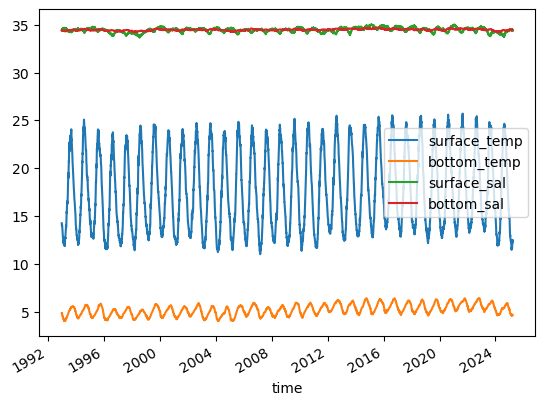

In [5]:
gom_glorys.set_index("time")[["surface_temp", "bottom_temp", "surface_sal", "bottom_sal"]].plot()

<Axes: xlabel='time'>

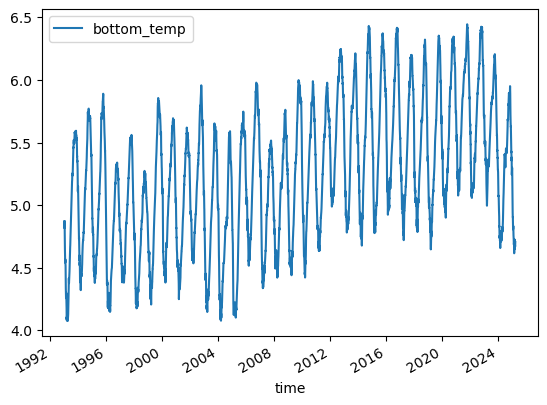

In [6]:
gom_glorys.plot("time", "bottom_temp")

### Save

In [7]:
# Save it out
gom_path = f"{box_path}RES_Data/GLORYs/GOM_Timeseries/"
gom_glorys.to_csv(f"{gom_path}Glorys_surfacebottom_GOM_ts.csv")